# Question III

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### On travaille dans le cadre du modèle de Black & Scholes. Dans toutes ces questions, on considère un call européen de maturité T et de strike K. On pourra prendre comme valeurs de référence : $S_0 = 100, K = 100, T = 1, r = 0.05, σ = 0.20, d = 12, B = 140, L = 95, N = 10^4, 10^5$

### 1. Tracer le prix Monte Carlo (avec intervalle de confiance) de l’option d’achat à barrière up-and-out de niveau B en fonction de S0 (comparer avec le call standard). Ajouter le prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter.

#### Option Barrière Up-and-Out

Une option barrière Up-And-Out devient sans valeur si le prix de l'actif sous-jacent atteint ou dépasse une certaine barrière $B$ avant l'échéance $T$.

Nous commençons avec la même équation de mouvement brownien pour l'actif sous-jacent $S(t)$ :

$$
dS = Srdt + S\sigma dz,
$$

où $dz$ est un terme stochastique suivant une distribution normale. Cela peut être discrétisé en utilisant un schéma d'Euler, donnant :

$$
S_T = S_t \exp \left( \left( r - \frac{1}{2} \sigma^2 \right)(T - t) + \sigma \sqrt{T - t} \, z \right),
$$

où $z \sim \mathcal{N}(0, 1)$.

#### Fonction de Payoff pour l'Option Barrière

Pour une option call barrière Up-And-Out, le payoff à l'échéance $T$ est défini comme suit :

$$
h(S_T) =
\begin{cases}
\max(S_T - X, 0) & \text{si } S_t < B \text{ pour tout } t \in [0, T], \\
0 & \text{si } S_t \geq B \text{ à n'importe quel } t \in [0, T].
\end{cases}
$$

Ainsi, il est nécessaire de vérifier la condition de barrière lors de la simulation Monte Carlo.

#### Formule Monte Carlo pour l'Option Barrière

Dans un cadre sans risque, le prix de l'option barrière Up-And-Out est donné par :

$$
C_{\text{barrière}}(T) = e^{-r(T-t)} \frac{1}{N} \sum_{i=1}^N h(S_T^i),
$$

où $N$ est le nombre de simulations Monte Carlo.

#### Formule fermée de l'option barrière par modèle de Black-Scholes

\begin{align*}
V_0 &= S_0 \left( \Phi\left(d_1\left(\frac{S_0}{K}, T\right)\right) - \Phi\left(d_1\left(\frac{S_0}{B}, T\right)\right) \right) \\
&- K e^{-rT} \left( \Phi\left(d_2\left(\frac{S_0}{K}, T\right)\right) - \Phi\left(d_2\left(\frac{S_0}{B}, T\right)\right) \right) \\
&- B \left(\frac{S_0}{B}\right)^{-2\frac{r}{\sigma^2}} \left( \Phi\left(d_1\left(\frac{B^2}{K S_0}, T\right)\right) - \Phi\left(d_1\left(\frac{B}{S_0}, T\right)\right) \right) \\
&+ K e^{-rT} \left(\frac{B}{S_0}\right)^{-2\frac{r}{\sigma^2} + 1} \left( \Phi\left(d_2\left(\frac{B^2}{K S_0}, T\right)\right) - \Phi\left(d_2\left(\frac{B}{S_0}, T\right)\right) \right),
\end{align*}

$$
d_1(x, \tau) = \frac{1}{\sigma \sqrt{\tau}} \left( \log(x) + \left( r + \frac{\sigma^2}{2} \right) \tau \right),
\quad
d_2(x, \tau) = d_1(x, \tau) - \sigma \sqrt{\tau}.
$$

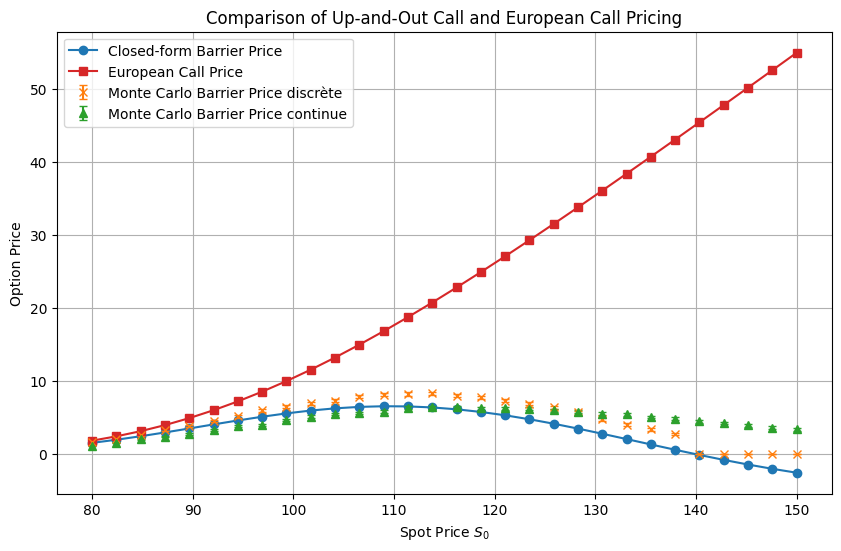

In [55]:
def price_european_call(S_0, K, T, r, sigma):
    """
    Prix du call européen avec Black-Scholes
    """
    def norm_pdf(x):
        """
        Fonction densité pour la loi normale standard
        """
        return 1.0 / np.sqrt(2 * np.pi) * np.exp(-0.5 * np.square(x))

    def norm_cdf(x):
        """
        Approximation de la fonction de répartition de la loi normale
        centrée réduite

        Référence :
        26.2.17 page 932 de abramowitz_and_stegun.pdf textbook on mathematical functions
        """
        k = 1.0 / (1.0 + 0.2316419 * abs(x))
        k_sum = k * (0.319381530 + k * (-0.356563782 + \
            k * (1.781477937 + k * (-1.821255978 + 1.330274429 * k))))

        if x >= 0.0:
            return 1.0 - (1.0 / ((2 * np.pi) ** 0.5)) * np.exp(-0.5 * x ** 2) * k_sum
        else:
            return 1.0 - norm_cdf(-x)


    d1 = (np.log(S_0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S_0 * norm_cdf(d1) - np.exp(-r * T) * K * norm_cdf(d2)

# Function to calculate closed-form up-and-out call price
def closed_form_barrier(S0, K, T, r, sig, B):
    def norm_pdf(x):
        return (1.0 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * np.square(x))

    def norm_cdf(x):
        k = 1.0 / (1.0 + 0.2316419 * abs(x))
        k_sum = k * (0.319381530 + k * (-0.356563782 + 
            k * (1.781477937 + k * (-1.821255978 + 1.330274429 * k))))
        if x >= 0.0:
            return 1.0 - (1.0 / ((2 * np.pi) ** 0.5)) * np.exp(-0.5 * x ** 2) * k_sum
        else:
            return 1.0 - norm_cdf(-x)

    d1 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r + sig**2 / 2) * t)
    d2 = lambda t, s: d1(t, s) - sig * np.sqrt(t)

    return (
        S0 * (norm_cdf(d1(T, S0 / K)) - norm_cdf(d1(T, S0 / B)))
        - np.exp(-r * T) * K * (norm_cdf(d2(T, S0 / K)) - norm_cdf(d2(T, S0 / B)))
        - B * (S0 / B) ** (-2 * r / sig**2) * (norm_cdf(d1(T, B**2 / (S0 * K))) - norm_cdf(d1(T, B / S0)))
        + np.exp(-r * T) * K * (S0 / B) ** (-2 * r / sig**2 + 1)
        * (norm_cdf(d2(T, B**2 / (S0 * K))) - norm_cdf(d2(T, B / S0)))
    )

# Function for Monte Carlo simulation variante discrète
def monte_carlo_discrete_barrier(S0, K, T, r, sig, B, n_simulations=10000, n_steps=200):
    dt = T / float(n_steps)
    discount_factor = np.exp(-r * T)
    payoffs = []
    
    Z = np.random.normal(size=(n_simulations, n_steps))
    dW = np.sqrt(dt) * Z
    drift = (r - 0.5 * sig**2) * dt
    diffusion = sig * dW
    log_S = np.cumsum(drift + diffusion, axis=1)
    S = np.zeros((n_simulations, n_steps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(log_S)
        
    max_prices = np.max(S, axis=1)
    mask = max_prices < B
    payoffs = np.zeros(n_simulations)
    payoffs[mask] = np.maximum(S[mask, -1] - K, 0)
    
    mean_price = np.mean(discount_factor * payoffs)
    std_dev = np.std(discount_factor * payoffs, ddof=1)
    n = len(payoffs)
    z = stats.norm.ppf(1 - (1 - 0.95) / 2)
    delta = z * std_dev / np.sqrt(n)
    
    return mean_price, mean_price - delta, mean_price + delta


def monte_carlo_continuous_barrier_condition(S0, K, T, r, sig, B, n_simulations=10000, alpha=0.95):
    dt = T
    discount_factor = np.exp(-r * T)
    
    # Simulate X_T and S_T
    Z = np.random.normal(size=n_simulations)
    X_T = np.log(S0) + (r - 0.5 * sig**2) * T + sig * np.sqrt(T) * Z
    S_T = np.exp(X_T)
    
    # Simulate the maximum M_T using the conditional formula
    U = np.random.uniform(size=n_simulations)
    M_T = 0.5 * (X_T + np.sqrt(np.square(X_T) - 2 * T * np.log(U)))
    S_max = np.exp(M_T)
    
    # Check for barrier breaches
    not_knocked_out = S_max < B  # Paths that did not breach the barrier
    
    # Calculate payoffs (zero for knocked-out paths)
    payoffs = np.zeros(n_simulations)
    payoffs[not_knocked_out] = np.maximum(S_T[not_knocked_out] - K, 0)
    
    # Compute mean and confidence interval
    mean_price = np.mean(discount_factor * payoffs)
    std_dev = np.std(discount_factor * payoffs, ddof=1)
    n = len(payoffs)
    z = stats.norm.ppf(1 - (1 - alpha) / 2)
    delta = z * std_dev / np.sqrt(n)
    
    return mean_price, mean_price - delta, mean_price + delta

# Option parameters
K = 100.0

T = 1.0
r = 0.05
sig = 0.2
B = 140.0
n_steps = 12
n_simulations = int( 1e4 )

# S0 values for comparison
S0_values = np.linspace(80, 150, 30)
closed_prices = []
european_call_prices = []

mean_discrete = []
lower_discrete = []
upper_discrete = []

mean_continuous = []
lower_continuous = []
upper_continuous = []


# Calculate prices for each S0
for S0 in S0_values:
    closed_prices.append(closed_form_barrier(S0, K, T, r, sig, B))
    european_call_prices.append(price_european_call(S0, K, T, r, sig))

for S0 in S0_values:
    # Discrete barrier
    mean, lower, upper = monte_carlo_discrete_barrier(S0, K, T, r, sig, B, n_simulations=n_simulations, n_steps=n_steps)
    mean_discrete.append(mean)
    lower_discrete.append(lower)
    upper_discrete.append(upper)
    
    # Continuous barrier
    mean, lower, upper = monte_carlo_continuous_barrier_condition(S0, K, T, r, sig, B, n_simulations=n_simulations)
    mean_continuous.append(mean)
    lower_continuous.append(lower)
    upper_continuous.append(upper)
    
plt.figure(figsize=(10, 6))

# Closed-form barrier price
plt.plot(S0_values, closed_prices, label='Closed-form Barrier Price', marker='o')

# Discrete Monte Carlo with error bars
plt.errorbar(S0_values, mean_discrete, yerr=[np.array(mean_discrete) - np.array(lower_discrete),
                                             np.array(upper_discrete) - np.array(mean_discrete)], 
             fmt='x', label='Monte Carlo Barrier Price discrète', capsize=3)

# Continuous Monte Carlo with error bars
plt.errorbar(S0_values, mean_continuous, yerr=[np.array(mean_continuous) - np.array(lower_continuous),
                                               np.array(upper_continuous) - np.array(mean_continuous)], 
             fmt='^', label='Monte Carlo Barrier Price continue', capsize=3)

# European call price
plt.plot(S0_values, european_call_prices, label='European Call Price', marker='s')

plt.title('Comparison of Up-and-Out Call and European Call Pricing')
plt.xlabel('Spot Price $S_0$')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()

plt.show()

L’écart observé entre les prix Monte Carlo et la formule fermée pour le call up-and-out s’explique par des différences sur le check que fait l'algorithme sur le franchissement de la barrière.

Dans la formule fermée, la formule regarde de façon continue si la barrière est franchie ou non $\forall t \in [0,T]$ , ce qui tend à augmenter la probabilité de désactivation de l’option et donc à réduire son prix.

En revanche, la méthode Monte Carlo examine le franchissement de la barrière à des instants discrets (définis par n_steps), ce qui laisse passer certaines trajectoires qui franchiraient la barrière en temps continu. Ce biais discretisationnel sous-estime la probabilité de désactivation, entraînant des prix Monte Carlo généralement plus élevés que la formule fermée.

Pour réduire cet écart, il est recommandé d'augmenter n_steps ou d'utiliser une correction par pont brownien pour capturer les franchissements intermédiaires.

On peut regarder que pour le cas de calculer le prix de l'option avec la variable continue, il faut utiliser plus de simulation pour avoir un prix plus proche de la formule fermée.

### 2. Tracer le prix Monte Carlo (avec intervalle de confiance) de l’option d’achat à barrière up-and-out (variante discrète) en fonction du nombre de dates d’observations. Ajouter le prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter.

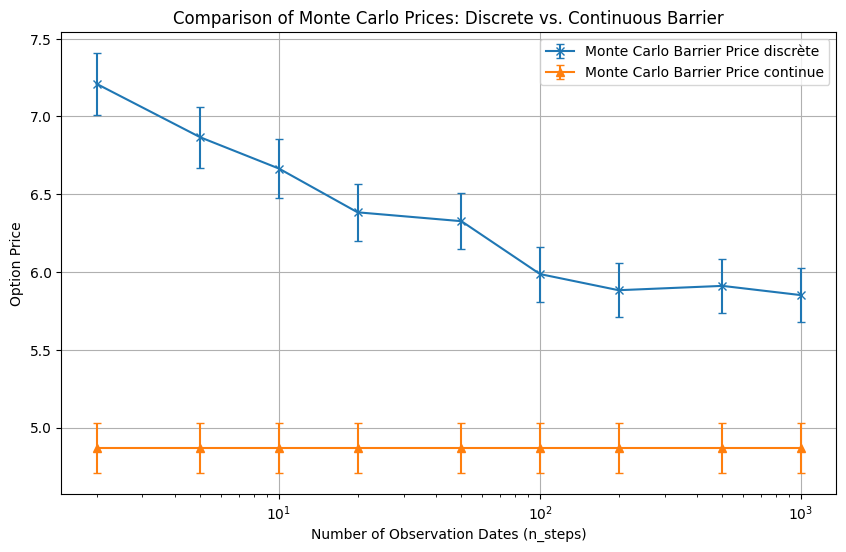

In [63]:
# Option parameters
S0 = 100.0  # Spot price
K = 100.0   # Strike price
T = 1.0     # Maturity in years
r = 0.05    # Risk-free rate
sig = 0.2   # Volatility
B = 140.0   # Barrier level
n_simulations = 10_000  # Number of simulations

# Range of n_steps (number of observation dates) to test
n_steps_values = [2, 5, 10, 20, 50, 100, 200, 500, 1000]

mean_discrete = []
lower_discrete = []
upper_discrete = []

mean_continuous = []
lower_continuous = []
upper_continuous = []

# Calculate prices for each n_steps value
for n_steps in n_steps_values:
    # Discrete barrier
    mean, lower, upper = monte_carlo_discrete_barrier(S0, K, T, r, sig, B, n_simulations=n_simulations, n_steps=n_steps)
    mean_discrete.append(mean)
    lower_discrete.append(lower)
    upper_discrete.append(upper)

# Continuous barrier (fixed, independent of n_steps)
mean, lower, upper = monte_carlo_continuous_barrier_condition(S0, K, T, r, sig, B, n_simulations=n_simulations)
mean_continuous = [mean] * len(n_steps_values)  # Same value for all n_steps
lower_continuous = [lower] * len(n_steps_values)
upper_continuous = [upper] * len(n_steps_values)

# Plot the results
plt.figure(figsize=(10, 6))

# Discrete Monte Carlo prices with error bars
plt.errorbar(n_steps_values, mean_discrete, 
             yerr=[np.array(mean_discrete) - np.array(lower_discrete), 
                   np.array(upper_discrete) - np.array(mean_discrete)], 
             fmt='x-', label='Monte Carlo Barrier Price discrète', capsize=3)

# Continuous Monte Carlo prices with error bars
plt.errorbar(n_steps_values, mean_continuous, 
             yerr=[np.array(mean_continuous) - np.array(lower_continuous), 
                   np.array(upper_continuous) - np.array(mean_continuous)], 
             fmt='^-', label='Monte Carlo Barrier Price continue', capsize=3)
#plt.yscale('log')
plt.xscale('log')
plt.title('Comparison of Monte Carlo Prices: Discrete vs. Continuous Barrier')
plt.xlabel('Number of Observation Dates (n_steps)')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()


### Analyse du graphique : Comparaison des prix Monte Carlo discrète et continue en fonction du nombre de dates d'observation $ n_{\text{steps}} $

#### 1. Observation principale
- Le prix de l'option Monte Carlo avec la **variante discrète** diminue à mesure que le **nombre de dates d'observation $ n_{\text{steps}} $** augmente.
- En revanche, le prix Monte Carlo pour la **variante continue** reste constant sur toute la gamme des valeurs de $ n_{\text{steps}} $.

#### 2. Convergence du prix Monte Carlo discrète vers le prix continu
- On observe que la **variante discrète** converge vers la **variante continue** lorsque le nombre de dates $ n_{\text{steps}} $ devient très grand. Cela reflète le fait que des observations plus fréquentes augmentent la probabilité de franchir la barrière, ce qui rapproche la simulation discrète du cas continu.

#### 3. Différence notable entre les prix discrète et continue
- La différence initiale importante entre les deux variantes s'explique par le fait que, pour des petites valeurs de $ n_{\text{steps}} $, la barrière est surveillée de manière plus espacée. Cela réduit la probabilité de franchir la barrière, entraînant un **prix plus élevé** pour la variante discrète par rapport à la variante continue.



#### 4. Conclusion
- Ce graphique illustre efficacement la **convergence** des prix Monte Carlo pour la variante discrète vers la solution continue.
- Il met également en évidence l’importance du nombre de dates d’observation dans la précision et la stabilité des estimations Monte Carlo pour les options à barrière.


### 3. Reprendre la question 1 pour un call down-and-in de niveau L.

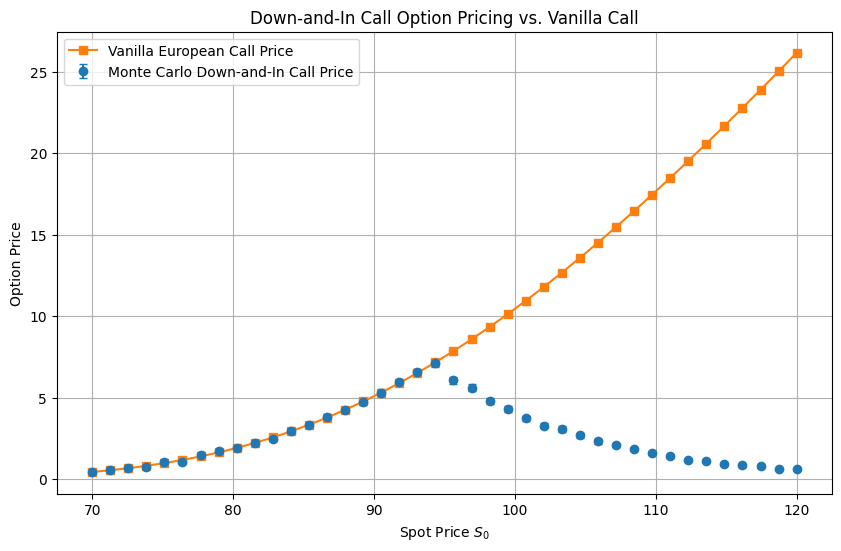

In [69]:
def monte_carlo_down_and_in_call(S0, K, T, r, sig, L, n_simulations=10000, n_steps=200, alpha=0.95):
    """
    Monte Carlo simulation for down-and-in call option with a discrete barrier.
    
    Parameters:
    S0 : float : Initial stock price
    K  : float : Strike price
    T  : float : Time to maturity
    r  : float : Risk-free interest rate
    sig : float : Volatility
    L  : float : Barrier level
    n_simulations : int : Number of simulations
    n_steps : int : Number of time steps
    alpha : float : Confidence level (default is 0.95 for 95% confidence interval)
    
    Returns:
    tuple : Estimated price, lower bound, upper bound of the down-and-in call option
    """
    dt = T / n_steps
    discount_factor = np.exp(-r * T)
    
    Z = np.random.normal(size=(n_simulations, n_steps))
    dW = np.sqrt(dt) * Z
    drift = (r - 0.5 * sig**2) * dt
    diffusion = sig * dW
    log_S = np.cumsum(drift + diffusion, axis=1)
    
    S = np.zeros((n_simulations, n_steps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(log_S)
    
    # Check if the barrier was breached
    min_prices = np.min(S, axis=1)
    breached = min_prices <= L  # Paths that breached the barrier
    
    # Payoff: If barrier breached, it's a European call payoff
    payoffs = np.zeros(n_simulations)
    payoffs[breached] = np.maximum(S[breached, -1] - K, 0)
    
    # Calculate mean and standard deviation of the payoffs
    mean_price =  np.mean(discount_factor * payoffs)
    std_dev = np.std(discount_factor * payoffs, ddof=1)
    
    # Confidence interval
    n = len(payoffs)
    z = stats.norm.ppf(1 - (1 - alpha) / 2)
    delta = z * std_dev / np.sqrt(n)
    
    return mean_price, mean_price - delta, mean_price + delta



# Define S0 values and compute prices with confidence intervals
S0_values = np.linspace(70, 120, 40)
K = 100.0   # Strike price
T = 1.0     # Maturity in years
r = 0.05    # Risk-free rate
sig = 0.2   # Volatility
L = 95.0    # Barrier level
n_simulations = 1_000  # Number of simulations
n_steps = 12

down_and_in_prices = []
lower_bounds = []
upper_bounds = []
vanilla_call_prices = []

for S0 in S0_values:
    mean, lower, upper = monte_carlo_down_and_in_call(S0, K, T, r, sig, L, n_simulations=10000, n_steps=200)
    down_and_in_prices.append(mean)
    lower_bounds.append(lower)
    upper_bounds.append(upper)
    vanilla_call_prices.append(price_european_call(S0, K, T, r, sig))

# Plot the results with confidence intervals
plt.figure(figsize=(10, 6))

# Down-and-in call prices with error bars
plt.errorbar(S0_values, down_and_in_prices, 
             yerr=[np.array(down_and_in_prices) - np.array(lower_bounds), 
                   np.array(upper_bounds) - np.array(down_and_in_prices)], 
             fmt='o', label='Monte Carlo Down-and-In Call Price', capsize=3)

# Vanilla call prices
plt.plot(S0_values, vanilla_call_prices, label='Vanilla European Call Price', marker='s')

plt.title('Down-and-In Call Option Pricing vs. Vanilla Call')
plt.xlabel('Spot Price $S_0$')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()


### Analyse du graphique : Comparaison entre le prix d'un call Down-and-In et le prix d'un call européen classique

#### 1. Observation principale
- Le **prix du call Down-and-In** est systématiquement inférieur au **prix du call européen** pour toutes les valeurs de \( S_0 \).
- Le prix du call Down-and-In tend vers zéro lorsque \( S_0 \) s'éloigne de la barrière \( L \), ce qui reflète la faible probabilité d'activation de l'option.
- L'intervalle de confiance (IC) pour les prix Monte Carlo est visible, indiquant une précision raisonnable des estimations.

#### 2. Explications
- **Différence de structure entre les options** :
  - Le call européen classique n'est soumis à aucune condition de barrière, ce qui signifie qu'il reste actif indépendamment de l'évolution de \( S_t \).
  - En revanche, le call Down-and-In nécessite que le **sous-jacent atteigne la barrière \( L \)** pour que l'option soit activée. Si la barrière n'est jamais atteinte, le payoff est nul.

- **Effet de la distance entre \( S_0 \) et \( L \)** :
  - Lorsque \( S_0 \) est **très supérieur à \( L \)**, la probabilité de franchir la barrière devient faible, entraînant un **prix proche de zéro** pour le call Down-and-In.
  - À mesure que \( S_0 \) approche de \( L \), la probabilité de franchir la barrière augmente, ce qui rend le prix du Down-and-In plus proche de celui du call européen.

- **Intervalle de confiance (IC)** :
  - L'IC des prix Monte Carlo pour le call Down-and-In reste raisonnablement **étroit**, démontrant que les simulations fournissent des résultats cohérents.
  - Les incertitudes semblent légèrement augmenter pour les valeurs de \( S_0 \) proches de \( L \), ce qui peut être dû à une plus grande variabilité des trajectoires proches de la barrière.

#### 3. Conclusion
- Le graphique illustre clairement que le **call Down-and-In** est un produit moins cher que le call européen en raison de la condition de barrière, ce qui le rend utile dans des stratégies d'options spécifiques.
- La relation entre \( S_0 \) et \( L \) est cruciale : plus \( S_0 \) est proche de \( L \), plus le Down-and-In se rapproche d'un call classique, tandis que pour \( S_0 \) éloigné de \( L \), l'option devient quasiment sans valeur.
- Ce résultat est cohérent avec les attentes théoriques pour les options barrières.


### 4. Implémenter un Monte Carlo conditionnel pour le pricing du call down-and-in (i.e. utiliser l’information disponible au franchissement de la barrière). Quel est la facteur de réduction de variance obtenu ? Comparer avec une réduction par variables antithétiques (comparer le coecients de réduction obtenu et le théorique estimé par simulation). Commenter.

The idea of the following algorithm to use the conditional Monte Carlo is to use the information available at the barrier crossing to reduce the variance of the Monte Carlo estimator. In practice, this means that we perform simulation until the price of the asset crosses the barrier. Afterwards, we know analitically the payoff of the option given by the Black-Scholes formula. This way, we can use the payoff as the value of the option and reduce the variance of the estimator.

In [78]:
def conditional_monte_carlo_down_and_in(S0, K, T, r, sig, L, n_simulations=10000, n_steps=200):
    """
    Conditional Monte Carlo simulation for down-and-in call option.
    
    Parameters:
    S0 : float : Initial stock price
    K  : float : Strike price
    T  : float : Time to maturity
    r  : float : Risk-free interest rate
    sig : float : Volatility
    L  : float : Barrier level
    n_simulations : int : Number of simulations
    n_steps : int : Number of time steps
    
    Returns:
    tuple : Estimated price, variance of the simulation
    """
    dt = T / n_steps
    discount_factor = np.exp(-r * T)
    
    Z = np.random.normal(size=(n_simulations, n_steps))
    dW = np.sqrt(dt) * Z
    drift = (r - 0.5 * sig**2) * dt
    diffusion = sig * dW
    log_S = np.cumsum(drift + diffusion, axis=1)
    
    S = np.zeros((n_simulations, n_steps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(log_S)
    
    payoffs = []
    for i in range(n_simulations):
        breached = False
        for j in range(1, n_steps + 1):
            if S[i, j] <= L:
                breached = True
                t_b = j * dt
                # Use Black-Scholes for remaining payoff from barrier
                if T - t_b > 0:
                    payoff = price_european_call(S[i, j], K, T - t_b, r, sig)
                else:
                    payoff = 0
                payoffs.append(np.exp(-r * t_b) * payoff)  # Discounted to current time
                break
        if not breached:
            payoffs.append(0)  # No payoff if barrier not breached
    
    # Calculate mean and variance
    mean_price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)
    
    return mean_price, variance



def monte_carlo_down_and_in_call_var(S0, K, T, r, sig, L, n_simulations=10000, n_steps=200, alpha=0.95):
    """
    Monte Carlo simulation for down-and-in call option with a discrete barrier.
    
    Parameters:
    S0 : float : Initial stock price
    K  : float : Strike price
    T  : float : Time to maturity
    r  : float : Risk-free interest rate
    sig : float : Volatility
    L  : float : Barrier level
    n_simulations : int : Number of simulations
    n_steps : int : Number of time steps
    alpha : float : Confidence level (default is 0.95 for 95% confidence interval)
    
    Returns:
    tuple : Estimated price, lower bound, upper bound of the down-and-in call option
    """
    dt = T / n_steps
    discount_factor = np.exp(-r * T)
    
    Z = np.random.normal(size=(n_simulations, n_steps))
    dW = np.sqrt(dt) * Z
    drift = (r - 0.5 * sig**2) * dt
    diffusion = sig * dW
    log_S = np.cumsum(drift + diffusion, axis=1)
    
    S = np.zeros((n_simulations, n_steps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(log_S)
    
    # Check if the barrier was breached
    min_prices = np.min(S, axis=1)
    breached = min_prices <= L  # Paths that breached the barrier
    
    # Payoff: If barrier breached, it's a European call payoff
    payoffs = np.zeros(n_simulations)
    payoffs[breached] = np.maximum(S[breached, -1] - K, 0)
    
    # Calculate mean and standard deviation of the payoffs
    mean_price = np.mean(discount_factor * payoffs)
    var = np.var(discount_factor * payoffs, ddof=1)
    return mean_price, var


def antithetic_monte_carlo_down_and_in_vectorized(S0, K, T, r, sig, L, n_simulations=10000, n_steps=200):
    """
    Vectorized Monte Carlo simulation with antithetic variates for down-and-in call option.
    
    Parameters:
    S0 : float : Initial stock price
    K  : float : Strike price
    T  : float : Time to maturity
    r  : float : Risk-free interest rate
    sig : float : Volatility
    L  : float : Barrier level
    n_simulations : int : Number of simulations (effective paths will be doubled)
    n_steps : int : Number of time steps
    
    Returns:
    tuple : Estimated price, variance of the simulation
    """
    dt = T / n_steps
    discount_factor = np.exp(-r * T)
    
    # Generate random normal variables and their antithetic counterparts
    Z = np.random.normal(size=(n_simulations, n_steps))
    dW = np.sqrt(dt) * Z
    dW_antithetic = -dW  # Antithetic variates

    # Simulate both original and antithetic paths in a single step
    log_S = np.cumsum((r - 0.5 * sig**2) * dt + sig * dW, axis=1)
    log_S_antithetic = np.cumsum((r - 0.5 * sig**2) * dt + sig * dW_antithetic, axis=1)
    
    # Combine original and antithetic paths
    S_original = S0 * np.exp(log_S)
    S_antithetic = S0 * np.exp(log_S_antithetic)
    S = np.concatenate((S_original, S_antithetic), axis=0)
    
    # Add initial prices
    S = np.hstack((np.full((2 * n_simulations, 1), S0), S))
    
    # Check if the barrier is breached
    min_prices = np.min(S, axis=1)
    breached = min_prices <= L  # Paths that breached the barrier
    
    # Payoff: If barrier breached, it's a European call payoff
    payoffs = np.zeros(2 * n_simulations)
    breached_indices = np.where(breached)[0]
    payoffs[breached] = np.maximum(S[breached_indices, -1] - K, 0)
    
    # Calculate mean and variance of the discounted payoffs
    discounted_payoffs = discount_factor * payoffs
    mean_price = np.mean(discounted_payoffs)
    variance = np.var(discounted_payoffs, ddof=1)
    
    return mean_price, variance



In [82]:
np.random.seed(42)

# Paramètres
S0 = 100.0       # spot initial
K = 100.0        # strike
barrier = 95.0   # barrière (down-and-in)
r = 0.05         # taux
sigma = 0.20     # volatilité
T = 1.0          # maturité (1 an)

N = 100_000      # nb de simulations
n_steps = 12     # nb de pas dans la simulation classique


cond_mc, var_cond_mc = conditional_monte_carlo_down_and_in(S0, K, T, r, sigma, barrier, n_simulations=N, n_steps=n_steps)
mc, var_mc = monte_carlo_down_and_in_call_var(S0, K, T, r, sigma, barrier, n_simulations=N, n_steps=n_steps)
antithetic_mc, var_antithetic_mc = antithetic_monte_carlo_down_and_in_vectorized(S0, K, T, r, sigma, barrier, n_simulations=N, n_steps=n_steps)

print(f"Monte Carlo classique: {mc:.4f} (variance: {var_mc:.6f})")
print(f"Monte Carlo conditionnel: {cond_mc:.4f} (variance: {var_cond_mc:.6f})")
print(f"Monte Carlo antithétique: {antithetic_mc:.4f} (variance: {var_antithetic_mc:.6f})")

# Reduction factor
reduction_factor_antithetic = var_mc / var_antithetic_mc
print(f"Réduction de la variance avec antithetic: {reduction_factor_antithetic:.2f}")

reduction_factor_cond = var_mc / var_cond_mc
print(f"Réduction de la variance avec conditionnel: {reduction_factor_cond:.2f}")

# Erreur relative
relative_error_antithetic = (antithetic_mc - mc) / mc * 100
print(f"Erreur relative avec antithetic: {relative_error_antithetic:.2f}%")
relative_error_cond = (cond_mc - mc) / mc * 100
print(f"Erreur relative avec conditionnel: {relative_error_cond:.2f}%")

Monte Carlo classique: 2.6028 (variance: 51.579915)
Monte Carlo conditionnel: 2.6423 (variance: 6.098373)
Monte Carlo antithétique: 2.6204 (variance: 51.483980)
Réduction de la variance avec antithetic: 1.00
Réduction de la variance avec conditionnel: 8.46
Erreur relative avec antithetic: 0.68%
Erreur relative avec conditionnel: 1.52%


### Analyse: Comparaison des méthodes Monte Carlo pour le pricing de l'option down-and-in avec différentes méthodes de réduction de variance

#### 1. Observations principales
- **Monte Carlo classique** :
  - Prix estimé : **2.6028**
  - Variance : **51.5799**
- **Monte Carlo conditionnel** :
  - Prix estimé : **2.6423**
  - Variance : **6.0984** (forte réduction par rapport au classique)
- **Monte Carlo antithétique** :
  - Prix estimé : **2.6204**
  - Variance : **51.4840** (similaire au classique)
  
- **Réduction de variance** :
  - **Antithetic** : **1.00** (pas de réduction significative)
  - **Conditionnel** : **8.46** (réduction importante)

- **Erreurs relatives** :
  - **Antithetic** : **0.68 %** 
  - **Conditionnel** : **1.52 %**

#### 2. Explications

##### Réduction de variance par les variables antithétiques
- La méthode des **variables antithétiques** vise à réduire la variance en équilibrant les fluctuations grâce à des chemins opposés (\( Z \) et \( -Z \)).
- Cependant, dans ce cas spécifique, il n'y a **pas de réduction significative de la variance** (réduction de variance proche de 1). Cela peut s'expliquer par :
  - Une **faible corrélation négative** entre les chemins opposés dans le cas d'une barrière down-and-in.
  - Les **chemins qui franchissent la barrière** n'exploitent pas pleinement le potentiel de réduction offert par les antithétiques.

##### Réduction de variance par Monte Carlo conditionnel
- Le **Monte Carlo conditionnel** utilise une information supplémentaire, à savoir que le prix de l'option est connu lorsque la barrière est franchie.
- Cette méthode permet une **réduction de la variance significative (facteur 8.46)** :
  - En remplaçant une partie aléatoire de la simulation par une **espérance conditionnelle analytique**, la dispersion des résultats est réduite.
  - Cela explique la variance beaucoup plus faible pour cette méthode.
  
##### Erreur relative
- Bien que le **Monte Carlo conditionnel** offre une réduction de variance notable, son **erreur relative** est légèrement plus élevée (**1.52 %**) par rapport à la méthode antithétique (**0.68 %**).
- Cela peut s'expliquer par des **approximations liées à l'espérance conditionnelle**, qui introduisent un biais dans l'estimation.

#### 3. Conclusions
- La méthode conditionnelle est clairement supérieure en termes de **réduction de variance**, ce qui est crucial pour des simulations nécessitant une précision accrue.
- Cependant, la **méthode antithétique** ne montre pas de gains significatifs pour ce type d'option, bien qu'elle maintienne une erreur relative plus faible.
- En pratique, le choix entre ces méthodes dépendra de :
  - La **complexité de calcul** (la conditionnelle nécessite plus d'implémentation analytique).
  - L'importance d'une **variance réduite** versus une **erreur relative faible**.


Hugo code

In [4]:
def reflection_probability(S0, barrier, x, sigma, T):
    """
    Reflection principle for a DOWN barrier B < S0.

    Returns P(barrier touched | S_T = x).
    """
    if x <= barrier:
        # barrière touchée, probabilité certaine
        return 1.0
    
    exponent = 2.0 * (np.log(barrier) - np.log(S0)) * (np.log(x) - np.log(barrier)) / (sigma**2 * T)
    
    return np.exp(exponent)


def simulate_call_DownIn_conditional(S0, K, barrier, r, sigma, T, N, seed=None):
    """
    Monte Carlo conditionnel :
    - On simule directement S_T ~ log-normal en 1 seul step.
    - On calcule p_hit = P(barrière touchée | S_T).
    - Le payoff conditionnel = max(S_T - K, 0) * p_hit.
    - On moyenne ce payoff conditionnel puis on actualise.
    - On retourne (prix_estime, variance_empirique).
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    payoffs = np.zeros(N)
    for m in range(N):
        Z = np.random.randn()
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        
        # Probabilité de toucher la barrière (conditionnel à ST)
        p_hit = reflection_probability(S0, barrier, ST, sigma, T)
        
        # Payoff conditionnel
        payoff_cond = max(ST - K, 0.0) * p_hit
        payoffs[m] = payoff_cond
    
    # Actualisation
    discounted_payoffs = np.exp(-r * T) * payoffs
    price_estimate = np.mean(discounted_payoffs)
    var_estimate   = np.var(discounted_payoffs, ddof=1)
    
    return price_estimate, var_estimate

if __name__ == "__main__":
    # Paramètres
    S0 = 100.0       # spot initial
    K = 100.0        # strike
    barrier = 95.0   # barrière (down-and-in)
    r = 0.05         # taux
    sigma = 0.20     # volatilité
    T = 1.0          # maturité (1 an)
    
    N = 100_000      # nb de simulations
    n_steps = 100    # nb de pas dans la simulation classique
    
    # Prix par la méthode classique
    price_naive, var_naive = simulate_call_DownIn(S0, K, barrier, r, sigma, T, N, n_steps, seed=123)
    
    # Prix par la méthode conditionnelle
    price_cond, var_cond = simulate_call_DownIn_conditional(S0, K, barrier, r, sigma, T, N, seed=123)
    
    print("=== Monte Carlo classique ===")
    print(f"Prix estimé  : {price_naive: .4f}")
    print(f"Variance     : {var_naive: .6f}")
    print()
    print("=== Monte Carlo conditionnel ===")
    print(f"Prix estimé  : {price_cond: .4f}")
    print(f"Variance     : {var_cond: .6f}")
    
    # Facteur de réduction de variance
    if var_cond > 0:
        print()
        print("=== Facteur de réduction de variance ===")
        print(f"Var_naive / Var_cond = {var_naive / var_cond: .2f}")

=== Monte Carlo classique ===
Prix estimé  :  3.9325
Variance     :  81.251620

=== Monte Carlo conditionnel ===
Prix estimé  :  4.8215
Variance     :  28.741665

=== Facteur de réduction de variance ===
Var_naive / Var_cond =  2.83


### 5. (Pour aller plus loin) Analyser les réductions de variance en fonction de la barrière L.

In [5]:
import scipy.stats as ss

In [6]:
import scipy.stats as ss
import numpy as np

# Option variables
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.05  # risk free rate
sig = 0.2  # diffusion coefficient or volatility
B = 140  # Barrier 1

d1 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r + sig**2 / 2) * t)
d2 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r - sig**2 / 2) * t)

closed_barrier_u = (
    S0 * (ss.norm.cdf(d1(T, S0 / K)) - ss.norm.cdf(d1(T, S0 / B)))
    - np.exp(-r * T) * K * (ss.norm.cdf(d2(T, S0 / K)) - ss.norm.cdf(d2(T, S0 / B)))
    - B * (S0 / B) ** (-2 * r / sig**2) * (ss.norm.cdf(d1(T, B**2 / (S0 * K))) - ss.norm.cdf(d1(T, B / S0)))
    + np.exp(-r * T)
    * K
    * (S0 / B) ** (-2 * r / sig**2 + 1)
    * (ss.norm.cdf(d2(T, B**2 / (S0 * K))) - ss.norm.cdf(d2(T, B / S0)))
)

print("The price of the Up and Out call option by closed formula is: ", closed_barrier_u)

The price of the Up and Out call option by closed formula is:  5.711043495879136


In [7]:
import numpy as np

# Option variables
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.05  # risk free rate
sig = 0.2  # diffusion coefficient or volatility
B = 140  # Barrier 1

# Custom normal distribution functions
def norm_pdf(x):
    """
    Probability density function for the standard normal distribution
    """
    return (1.0 / ((2 * np.pi) ** 0.5)) * np.exp(-0.5 * (x ** 2))

def norm_cdf(x):
    """
    Approximation of the cumulative distribution function for the standard normal distribution

    Reference:
    26.2.17 page 932 of abramowitz_and_stegun.pdf textbook on mathematical functions
    """
    k = 1.0 / (1.0 + 0.2316419 * abs(x))
    k_sum = k * (0.319381530 + k * (-0.356563782 + \
        k * (1.781477937 + k * (-1.821255978 + 1.330274429 * k))))

    if x >= 0.0:
        return 1.0 - (1.0 / ((2 * np.pi) ** 0.5)) * np.exp(-0.5 * x ** 2) * k_sum
    else:
        return 1.0 - norm_cdf(-x)

# Define d1 and d2
d1 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r + sig**2 / 2) * t)
d2 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r - sig**2 / 2) * t)

# Barrier option pricing formula using custom norm_cdf
closed_barrier_u = (
    S0 * (norm_cdf(d1(T, S0 / K)) - norm_cdf(d1(T, S0 / B)))
    - np.exp(-r * T) * K * (norm_cdf(d2(T, S0 / K)) - norm_cdf(d2(T, S0 / B)))
    - B * (S0 / B) ** (-2 * r / sig**2) * (norm_cdf(d1(T, B**2 / (S0 * K))) - norm_cdf(d1(T, B / S0)))
    + np.exp(-r * T)
    * K
    * (S0 / B) ** (-2 * r / sig**2 + 1)
    * (norm_cdf(d2(T, B**2 / (S0 * K))) - norm_cdf(d2(T, B / S0)))
)

print("The price of the Up and Out call option by closed formula is: ", closed_barrier_u)

The price of the Up and Out call option by closed formula is:  5.711046807706693


In [8]:
# Option variables
S0 = 100.0  # spot stock price
K = 100.0  # strike price
T = 1.0  # maturity in years
r = 0.05  # risk-free rate
sig = 0.2  # volatility
B = 140.0  # barrier price
n_simulations = 100_000  # number of simulations
n_steps = 252  # number of time steps (e.g., daily)

# Monte Carlo simulation
np.random.seed(42)  # For reproducibility

dt = T / n_steps  # Time step size
discount_factor = np.exp(-r * T)  # Discount factor for present value

# Simulate stock price paths
payoffs = []
for _ in range(n_simulations):
    S = S0
    breached_barrier = False
    for _ in range(n_steps):
        # Simulate next price
        dS = S * (r * dt + sig * np.sqrt(dt) * np.random.normal())
        S += dS
        # Check if barrier is breached
        if S >= B:
            breached_barrier = True
            break  # No need to continue this path

    # Calculate payoff if barrier not breached
    if not breached_barrier:
        payoff = max(S - K, 0)  # Intrinsic value at maturity
        payoffs.append(payoff)

# Average discounted payoff
option_price = discount_factor * np.mean(payoffs)

print("The price of the Up-and-Out call option using Monte Carlo simulation is: ", option_price)

The price of the Up-and-Out call option using Monte Carlo simulation is:  6.683746103905937


ATTENTION CODE QUI MARCHE POUR QUESTION 1 ET 2 PARTIELLEMENT

Version continue MARCHE conditionnelle (non) backcheck montre que cela ne marche pas !!

In [9]:
import numpy as np
from scipy.stats import norm

# Parameters for the Black-Scholes model
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
B = 103   # Barrier level
N = 100000  # Number of Monte Carlo simulations

# Function to simulate terminal stock price S_T
def simulate_terminal_stock_price(S0, T, r, sigma, N):
    Z = np.random.normal(size=N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    return ST, Z

# Function to conditionally sample max(S) given S_T
def simulate_conditional_maximum(ST, Z, T):
    U = np.random.uniform(size=len(ST))
    conditional_max = ST * np.exp(np.sqrt(2 * T) * norm.ppf(U))
    return conditional_max

# Monte Carlo simulation for up-and-out call pricing
def monte_carlo_call_up_and_out(S0, K, T, r, sigma, B, N):
    # Simulate terminal stock price and Brownian increments
    ST, Z = simulate_terminal_stock_price(S0, T, r, sigma, N)

    # Simulate the maximum conditional on S_T
    max_ST = simulate_conditional_maximum(ST, Z, T)

    # Calculate payoffs with barrier condition
    payoffs = np.where(max_ST < B, np.maximum(ST - K, 0), 0)

    # Discount to present value
    discounted_payoff = np.exp(-r * T) * payoffs

    # Monte Carlo estimate of the option price
    option_price = np.mean(discounted_payoff)
    
    # Confidence interval
    std_error = np.std(discounted_payoff) / np.sqrt(N)
    conf_interval = (option_price - 1.96 * std_error, option_price + 1.96 * std_error)

    return option_price, conf_interval

# Run the Monte Carlo simulation
option_price, conf_interval = monte_carlo_call_up_and_out(S0, K, T, r, sigma, B, N)

print(f"Call Up-and-Out Option Price: {option_price:.4f}")
print(f"95% Confidence Interval: ({conf_interval[0]:.4f}, {conf_interval[1]:.4f})")

Call Up-and-Out Option Price: 4.4493
95% Confidence Interval: (4.3839, 4.5146)


Version Discrète ?

In [10]:
import numpy as np

# Paramètres du modèle
S0 = 100  # Prix initial de l'actif sous-jacent
K = 100  # Prix d'exercice
B = 140  # Barrière
T = 1.0  # Maturité (en années)
r = 0.05  # Taux sans risque
sigma = 0.2  # Volatilité
n_simulations = 100000  # Nombre de trajectoires Monte Carlo
n_steps = 50  # Nombre de pas de temps dans une année

dt = T / n_steps  # Taille du pas de temps
k = (1 / sigma) * np.log(K / S0)  # Constante k
b = (1 / sigma) * np.log(B / S0)  # Constante b

# Fonction pour simuler M_T^X conditionnellement à X_T = x
def simulate_conditional_maximum(X_T, T, sigma, n_steps):
    U = np.random.uniform(0, 1, len(X_T))
    m = (X_T + np.sqrt(X_T**2 - 2 * T * np.log(U))) / 2
    return m

# Fonction pour simuler les trajectoires et calculer la valeur de l'option
def monte_carlo_call_up_and_out(S0, K, B, T, r, sigma, n_simulations, n_steps):
    dt = T / n_steps

    # Simuler les trajectoires du processus log-normal
    X = np.zeros((n_simulations, n_steps + 1))
    X[:, 0] = 0  # Initialisation de X_0

    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_simulations)  # Bruit gaussien standard
        X[:, t] = X[:, t - 1] + (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    # Dernière valeur du processus
    X_T = X[:, -1]
    
    # Simuler le maximum conditionnel M_T^X
    M_T = simulate_conditional_maximum(X_T, T, sigma, n_steps)
    
    # Calcul des prix finaux et du payoff
    S_T = S0 * np.exp(sigma * X_T)  # Prix final S_T
    payoffs = np.exp(-r * T) * np.maximum(S_T - K, 0) * (X_T > k) * (M_T < b)

    return np.mean(payoffs)

# Exécution de la simulation Monte Carlo
option_value = monte_carlo_call_up_and_out(S0, K, B, T, r, sigma, n_simulations, n_steps)
print(f"Valeur estimée de l'option call up-and-out : {option_value:.4f}")


Valeur estimée de l'option call up-and-out : 1.8506


In [ ]:
# correction

import numpy as np
import scipy.stats as ss
from scipy.stats import norm

# Parameters for the Black-Scholes model
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sig = 0.2  # Volatility
B = 140   # Barrier level

np.random.seed(seed=42)
N = 10000
paths = 50000
dt = T / (N - 1)  # time interval

beta1 = 0.5826
B = B * np.exp(-beta1 * np.sqrt(dt) * sig)

# path generation
X_0 = np.zeros((paths, 1))
increments = ss.norm.rvs(loc=(r - sig**2 / 2) * dt, scale=np.sqrt(dt) * sig, size=(paths, N - 1))
X = np.concatenate((X_0, increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

M = np.amax(S, axis=1)  # maximum of each path

# Up and Out   --  Discounted expected payoff
MC_barrier_u = np.exp(-r * T) * (np.maximum(S[:, -1] - K, 0) @ (M < B)) / paths
barrier_std_err_u = np.exp(-r * T) * ss.sem((np.maximum(S[:, -1] - K, 0) * (M < B)))

print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier_u)
print("with standard error: ", barrier_std_err_u)
print()

In [5]:
# correction

import numpy as np
import scipy.stats as ss
from scipy.stats import norm

# Parameters for the Black-Scholes model
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sig = 0.2  # Volatility
B = 140   # Barrier level

np.random.seed(seed=42)
N = 10000
paths = 50000
dt = T / (N - 1)  # time interval

# path generation
X_0 = np.zeros((paths, 1))
increments = ss.norm.rvs(loc=(r - sig**2 / 2) * dt, scale=np.sqrt(dt) * sig, size=(paths, N - 1))
X = np.concatenate((X_0, increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

M = np.amax(S, axis=1)  # maximum of each path

# Up and Out   --  Discounted expected payoff
MC_barrier_u = np.exp(-r * T) * (np.maximum(S[:, -1] - K, 0) @ (M < B)) / paths
barrier_std_err_u = np.exp(-r * T) * ss.sem((np.maximum(S[:, -1] - K, 0) * (M < B)))

print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier_u)
print("with standard error: ", barrier_std_err_u)
print()

The price of the Up and Out call option by Monte Carlo is:  5.735458814160109
with standard error:  0.03909054366504976



In [9]:
# correction

import numpy as np
import scipy.stats as ss
from scipy.stats import norm

# Parameters for the Black-Scholes model
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sig = 0.2  # Volatility
B = 103   # Barrier level

np.random.seed(seed=42)
N = 10000
paths = 50000
dt = T / (N - 1)  # time interval


# path generation
X_0 = np.zeros((paths, 1))
increments = ss.norm.rvs(loc=(r - sig**2 / 2) * dt, scale=np.sqrt(dt) * sig, size=(paths, N - 1))
X = np.concatenate((X_0, increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

M = np.amax(S, axis=1)  # maximum of each path

# Up and Out   --  Discounted expected payoff
MC_barrier_u = np.exp(-r * T) * (np.maximum(S[:, -1] - K, 0) @ (M < B)) / paths
barrier_std_err_u = np.exp(-r * T) * ss.sem((np.maximum(S[:, -1] - K, 0) * (M < B)))

print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier_u)
print("with standard error: ", barrier_std_err_u)
print()

The price of the Up and Out call option by Monte Carlo is:  0.0012195014050543462
with standard error:  0.0001936286620634847



In [8]:
# correction

import numpy as np
import scipy.stats as ss
from scipy.stats import norm

# Parameters for the Black-Scholes model
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sig = 0.2  # Volatility
B = 103   # Barrier level

np.random.seed(seed=42)
N = 10000
paths = 50000
dt = T / (N - 1)  # time interval

beta1 = 0.5826
B = B * np.exp(-beta1 * np.sqrt(dt) * sig)

# path generation
X_0 = np.zeros((paths, 1))
increments = ss.norm.rvs(loc=(r - sig**2 / 2) * dt, scale=np.sqrt(dt) * sig, size=(paths, N - 1))
X = np.concatenate((X_0, increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

M = np.amax(S, axis=1)  # maximum of each path

# Up and Out   --  Discounted expected payoff
MC_barrier_u = np.exp(-r * T) * (np.maximum(S[:, -1] - K, 0) @ (M < B)) / paths
barrier_std_err_u = np.exp(-r * T) * ss.sem((np.maximum(S[:, -1] - K, 0) * (M < B)))

print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier_u)
print("with standard error: ", barrier_std_err_u)
print()

The price of the Up and Out call option by Monte Carlo is:  0.0011253671159101731
with standard error:  0.00018629064577258336

